# Selection on GPS tracks

Our focus on this section concern the selection process on GPS tracks. Given a selection query q, the objective is to find the GPS tracks whose satisfy a temporal or a spatial properties overlap with q. In addition, the process allows the retrieval of tracks that satisfy this properties with q.

Selection is performed by a selector object, containing an arbitrary number of constraints, combined by OR, AND or XOR operator. Since only a single operator is allowed in the selector, a "global selector" is provided to the users to combine the output of several individual selectors. Again, the output may be combined with OR, AND or XOR.

Constraints may be based on:

    - a geometrical shape (Rectangle, circle or polygon in Geometrics). This is the standard type of constraint. Different modes are:

         - MODE_CROSSES: tracks crossing shape interior/boundary are selected
         - MODE_INSIDE : tracks remaining fully inside the shape are selected
         - MODE_GETS_IN: tracks getting in (at least once) shape are selected
         - MODE_INSIDE : tracks getting out (at least once) shape are selected

    - a track t as a reference. Available modes are:

         - MODE_CROSSES : tracks  intersecting t (at least once) are selected
         - MODE_PARALLEL: tracks  following t are selected

    - a "toll gate" segment, defined by two Coords objects: tracks crossing (at least once) the toll gate are selected 

All these constraint may be provided with an additional time constraint, specifying the time interval (between two ObsTime dates) where crossing / containing / getting in / getting out... operations are tested. Besides, there are two types of selection:

    - TYPE_SELECT: tracks abiding by constraints are returned as they are
    - TYPE_CUT_AND_SELECT: tracks abiding by constraints are cut and returned

## Import de la librairie tracklib

In [1]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# Import de tracklib

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Loading the GPS track

In [2]:
import matplotlib.pyplot as plt

from tracklib.core.ObsTime import ObsTime
from tracklib.io.TrackReader import TrackReader

ObsTime.setReadFormat("4Y/2M/2D 2h:2m:2s")
trackpath = '/home/marie-dominique/tracklib/tracklib/data/gpx/utgtrack-22245.csv'

trace = TrackReader.readFromCsv(path=trackpath, id_E=0, id_N=1, id_T=6,
                                  srid="GeoCoords", h=1,
                                  separator = ',', verbose = False)
trace.toENUCoordsIfNeeded()
trace.summary()


-------------------------------------
GPS track #utgtrack-22245 of user 0:
-------------------------------------
  Nb of pt(s):   52
  Ref sys id   : ENU
  Starting at  : 12/07/2019 15:42:35
  Ending at    : 12/07/2019 16:48:16
  Duration     : 3941.000 s
  Length       : 1325.334 m
-------------------------------------



## Create two shapes to select the tracks: a circle and a rectangle

<Axes: title={'center': 'Original track'}, xlabel='E (m)', ylabel='N (m)'>

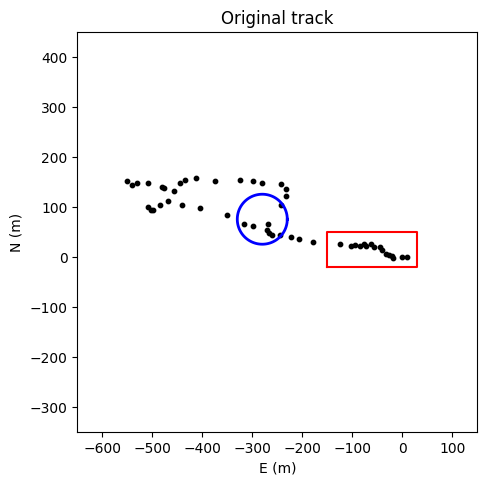

In [3]:
from tracklib.core.ObsCoords import ENUCoords
import tracklib.algo.Geometrics as Geometrics

# Plot the GPS track
fig = plt.figure(figsize = (4, 4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Original track")
plt.xlim([-650,150])#.set_xlabel('x')
plt.ylim([-350,450])#.set_xlabel('x')
trace.plot(sym="ko", pointsize=10, append=ax)

# shape rectangle
ll = ENUCoords(-150, -20)
ur = ENUCoords(30, 50)
bbox = Geometrics.Rectangle(ll, ur)
bbox.plot(append=ax)

# shape circle
center = ENUCoords(-280, 75)
circle = Geometrics.Circle(center, 50)
circle.plot('b-', append=ax, linewidth=2)

## Example 1

A constraint based on a geometrical shape (red rectangle) and mode CROSSES to select tracks crossing shape interior/boundary.

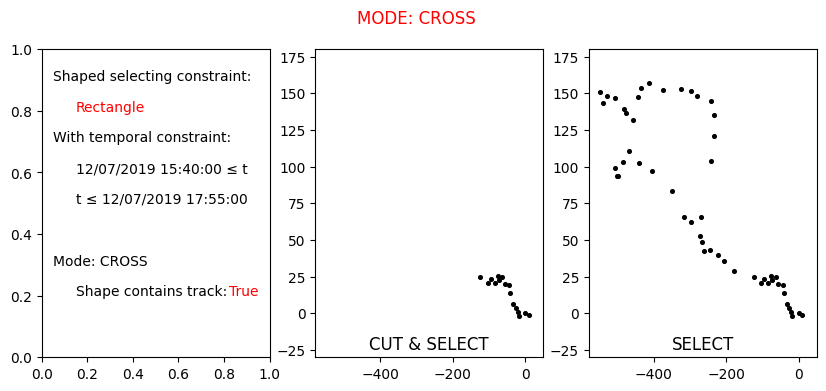

In [4]:
from tracklib.core.TrackCollection import TrackCollection
from tracklib.algo.Selection import Constraint, TimeConstraint
from tracklib.algo.Selection import MODE_INSIDE, MODE_CROSSES, MODE_GETS_IN
from tracklib.algo.Selection import TYPE_CUT_AND_SELECT, TYPE_SELECT

# Time Constraint
t3 = TimeConstraint()
t3.setMinTimestamp(ObsTime('2019-07-12 15:40:00'))
t3.setMaxTimestamp(ObsTime('2019-07-12 17:55:00'))

# A geometrical shape
fig = plt.figure(figsize = (10, 4))
fig.suptitle('MODE: CROSS', color='red')

ax1 = fig.add_subplot(131)
ax1.text(0.05, 0.9, "Shaped selecting constraint:")
ax1.text(0.15, 0.8, str(type(bbox))[33:-2], color='r')
ax1.text(0.05, 0.7, "With temporal constraint:")
ax1.text(0.15, 0.6, str(t3.minTimestamp) + " ≤ t ")
ax1.text(0.15, 0.5, "t ≤ " + str(t3.maxTimestamp))
c1 = Constraint(shape=bbox, time = t3, mode=MODE_CROSSES)
ax1.text(0.05, 0.3, "Mode: CROSS")
ax1.text(0.15, 0.2, "Shape contains track: ")
ax1.text(0.82, 0.2, str(c1.contains(trace)), color='r')

ax2 = fig.add_subplot(132)
plt.title('CUT & SELECT', y=-0.001)
plt.xlim([-580, 50])
plt.ylim([-30, 180])
c = Constraint(shape=bbox, time = t3, type=TYPE_CUT_AND_SELECT, mode=MODE_CROSSES)
selectedTracks = c.select(TrackCollection([trace]))
selectedTracks[0].plot(sym="ko", pointsize=7, append=ax2)
plt.xlabel("")
plt.ylabel("")

ax3 = fig.add_subplot(133)
plt.title('SELECT', y=-0.001)
plt.xlim([-580, 50])
plt.ylim([-30, 180])
c3 = Constraint(shape=bbox, time = t3, type=TYPE_SELECT, mode=MODE_CROSSES)
selectedTracks = c3.select(TrackCollection([trace]))
if selectedTracks.size() > 0:
    selectedTracks[0].plot(sym="ko", pointsize=7, append=ax3)
plt.xlabel("")
plt.ylabel("")

plt.show()

## Example 2

A constraint based on a geometrical shape (red rectangle) and mode INSIDE to select tracks remaining fully inside the shape

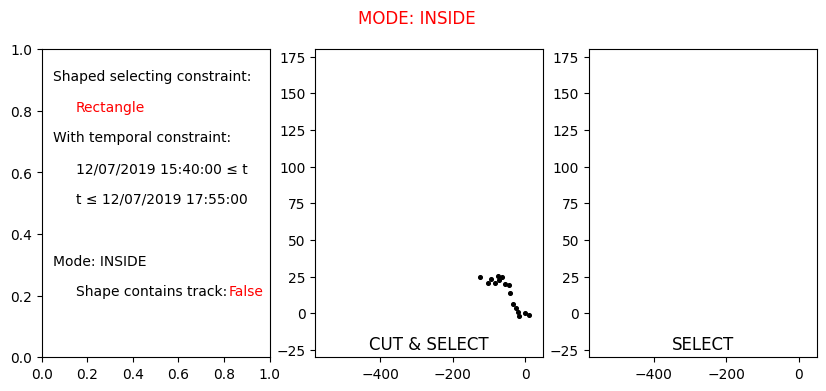

In [5]:
# A geometrical shape
fig = plt.figure(figsize = (10, 4))
fig.suptitle('MODE: INSIDE', color='red')

ax1 = fig.add_subplot(131)
ax1.text(0.05, 0.9, "Shaped selecting constraint:")
ax1.text(0.15, 0.8, str(type(bbox))[33:-2], color='r')
ax1.text(0.05, 0.7, "With temporal constraint:")
ax1.text(0.15, 0.6, str(t3.minTimestamp) + " ≤ t ")
ax1.text(0.15, 0.5, "t ≤ " + str(t3.maxTimestamp))
c1 = Constraint(shape=bbox, time = t3, mode=MODE_INSIDE)
ax1.text(0.05, 0.3, "Mode: INSIDE")
ax1.text(0.15, 0.2, "Shape contains track: ")
ax1.text(0.82, 0.2, str(c1.contains(trace)), color='r')

ax2 = fig.add_subplot(132)
plt.title('CUT & SELECT', y=-0.001)
plt.xlim([-580, 50])
plt.ylim([-30, 180])
c = Constraint(shape=bbox, time = t3, type=TYPE_CUT_AND_SELECT, mode=MODE_INSIDE)
selectedTracks = c.select(TrackCollection([trace]))
selectedTracks[0].plot(sym="ko", pointsize=7, append=ax2)
plt.xlabel("")
plt.ylabel("")

ax3 = fig.add_subplot(133)
plt.title('SELECT', y=-0.001)
plt.xlim([-580, 50])
plt.ylim([-30, 180])
c3 = Constraint(shape=bbox, time = t3, type=TYPE_SELECT, mode=MODE_INSIDE)
selectedTracks = c3.select(TrackCollection([trace]))
if selectedTracks.size() > 0:
    selectedTracks[0].plot(sym="ko", pointsize=7, append=ax3)

plt.show()

## Example 3

A constraint based on a geometrical shape (blue circle) and mode GETS_IN to select tracks getting in (at least once) shape

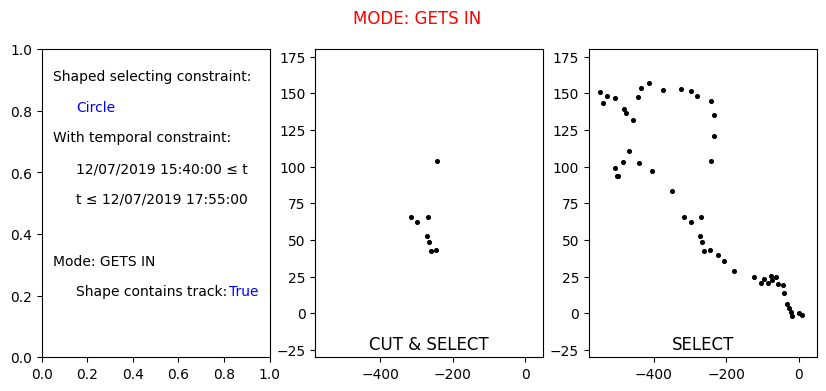

In [6]:
# A geometrical shape
fig = plt.figure(figsize = (10, 4))
fig.suptitle('MODE: GETS IN', color='red')

ax1 = fig.add_subplot(131)
ax1.text(0.05, 0.9, "Shaped selecting constraint:")
ax1.text(0.15, 0.8, str(type(circle))[33:-2], color='b')
ax1.text(0.05, 0.7, "With temporal constraint:")
ax1.text(0.15, 0.6, str(t3.minTimestamp) + " ≤ t ")
ax1.text(0.15, 0.5, "t ≤ " + str(t3.maxTimestamp))
c1 = Constraint(shape=circle, time = t3, mode=MODE_GETS_IN)
ax1.text(0.05, 0.3, "Mode: GETS IN")
ax1.text(0.15, 0.2, "Shape contains track: ")
ax1.text(0.82, 0.2, str(c1.contains(trace)), color='b')

ax2 = fig.add_subplot(132)
plt.title('CUT & SELECT', y=-0.001)
plt.xlim([-580, 50])
plt.ylim([-30, 180])
c = Constraint(shape=circle, time = t3, type=TYPE_CUT_AND_SELECT, mode=MODE_GETS_IN)
selectedTracks = c.select(TrackCollection([trace]))
selectedTracks[0].plot(sym="ko", pointsize=7, append=ax2)
plt.xlabel("")
plt.ylabel("")

ax3 = fig.add_subplot(133)
plt.title('SELECT', y=-0.001)
plt.xlim([-580, 50])
plt.ylim([-30, 180])
c3 = Constraint(shape=circle, time = t3, type=TYPE_SELECT, mode=MODE_GETS_IN)
selectedTracks = c3.select(TrackCollection([trace]))
if selectedTracks.size() > 0:
    selectedTracks[0].plot(sym="ko", pointsize=7, append=ax3)
plt.xlabel("")
plt.ylabel("")

plt.show()